In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

Parameter for the target mixture of Gaussians (set sigma to 0 to obtain point dirac masses)

In [189]:
mu = torch.randn(2,5)*8
mu = torch.tensor(([-1,-1], [1.3,-.7], [0,1.2])).T*4 # mean
K = mu.shape[1]
sigma = torch.zeros(K)
a = torch.ones(K)/K # weight, should sum to 1

Closed form expression for the score $\eta_t = \nabla \log(\rho_t)$

In [190]:
def gauss(x,m,s): return 1/( 2*torch.tensor(torch.pi) * s**2 ) * torch.exp( -( (x-m[:,None])**2 ).sum(axis=0) / (2*s**2) )
def gaus_mixture(x,mu,sigma,a):
    y = torch.zeros(x.shape[1])
    for i in range(len(a)):
        y = y + a[i] * gauss(x,mu[:,i],sigma[i])
    return y
def rho(x,t):
    sigma_t = torch.sqrt( torch.exp(-2*t)*sigma**2 + 1-torch.exp(-2*t) )
    return gaus_mixture(x, mu*torch.exp(-t), sigma_t,a)
def eta(x,t): 
    x1 = x.detach().clone()
    x1.requires_grad = True
    L = torch.sum( rho(x1,t) )
    L.backward()
    return x1.grad / rho(x,t)[None,:]

Backward diffusion 
$$
    dY_t = Y_t + (1+\alpha) \eta_t(Y_t) + \sqrt{2\alpha} dW_t
$$
Set $\alpha=0$ to obtain a deterministic evolution.

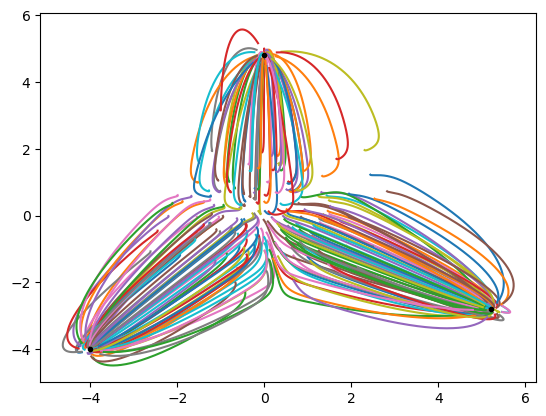

In [191]:
# set alpha=0 to obtain deterministic paths
alpha = .03
alpha = 0 # pure advection

T = 20 # final time
N = 2500 # number of steps
tau = T / N # step size
P = 200 # particules

Y = torch.zeros((2,P,N))
Y[:,:,0] = torch.randn((2,P)) # initial positions (Gaussian)
t = torch.tensor(T)
for i in range(N-1):
    Y[:,:,i+1] = Y[:,:,i]  + tau * ( Y[:,:,i] + (1+alpha)*eta(Y[:,:,i],t) ) + torch.sqrt(2 * torch.tensor(tau * alpha)) * torch.randn((2,P))
    t = t-tau

# display trajectories
for k in range(P):
    plt.plot( Y[0,k,:], Y[1,k,:], '-' )
plt.plot( mu[0,:], mu[1,:], 'k.' )